In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

Final__CLs_output_df = pd.read_csv("../csv-files/CLs_predictions/4l_128n_75e_0.005lr_MAE_with_all_data.csv")
all_CLs_output_df = pd.read_csv("../csv-files/CLs_predictions/4l_128n_EWKino_with_all_CLs_predictions.csv")
#output_df = pd.read_csv("../csv-files/EWKino.csv")

CLs_labels = ['FullHad', '1Lbb', '2L0J', '2L2J', 'Compressed', '3LOffshell', '3LOnshell', '4L', 'DisappearingTrack', 'h_to_inv', 'mA']

/tmp/ipykernel_28007/2987809151.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [22]:
def exclusions_by_bin(df, CLs_name, num_bins):
    
    # Get 1st and 2nd neutralino masses for each SUSY model
    m_chi_1p = df["m_chi_1p"]
    m_chi_10 = df["m_chi_10"]
    
    # Create mass bins for plotting
    M1_bins = np.linspace(0, 1200, num_bins+1)
    M2_bins = np.linspace(0, 500, num_bins+1)
    
    frac_excluded = []
    total_models = []
    
    for i in range(num_bins):
        
        frac_excluded_row = []
        total_models_row = []
        
        for j in range(num_bins):
            
            # Select models in particular bin
            bin_mask = (m_chi_1p >= M1_bins[j]) & (m_chi_1p < M1_bins[j+1]) & (m_chi_10 >= M2_bins[i]) & (m_chi_10 < M2_bins[i+1])
            
            # Get number of excluded models and total models in bin
            bin_excluded = (df[bin_mask][CLs_name] < 0.05).sum()
            bin_total = (df[bin_mask][CLs_name] < 2).sum()
            
            # Add fraction excluded in bin to heatmap array
            if bin_total != 0:
                bin_frac_excluded = bin_excluded / bin_total
            else:
                bin_frac_excluded = float('nan')
                        
            frac_excluded_row.append(bin_frac_excluded)
            
            if bin_total == 0:
                bin_total = float('nan')
            total_models_row.append(bin_total)
            
        frac_excluded.append(frac_excluded_row)
        total_models.append(total_models_row)
    
    # Convert arrays into a better form for heatmap plotting
    frac_excluded = np.array(frac_excluded)
    total_models = np.array(total_models)
    
    return frac_excluded, total_models

In [23]:
def recreate_figure_4_7a_from_BenH_thesis(df, num_bins):
    
    plt.style.use('default')
    
    true_frac_excluded, total_models = exclusions_by_bin(df, CLs_name='FullHad__ObsCLs', num_bins=num_bins)
    pred_frac_excluded, total_models = exclusions_by_bin(df, CLs_name='Predicted_FullHad_CLs', num_bins=num_bins)
    
    # Make 2D heatmap plots
    fig_x=np.linspace(0, 1200, num_bins)
    fig_y=np.linspace(0, 500, num_bins)
    
    fig_true = px.imshow(true_frac_excluded, 
                         labels=dict(x="m_chi_1p [GeV]", y="m_chi_10 [GeV]", color="Fraction of models excluded"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="EWKino scan, FullHad exclusion", aspect='square')
    
    fig_pred = px.imshow(pred_frac_excluded, 
                         labels=dict(x="m_chi_1p [GeV]", y="m_chi_10 [GeV]", color="Fraction of models excluded"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="EWKino scan, Predicted FullHad exclusion", aspect='square')
    
    fig_diff = px.imshow(np.abs(true_frac_excluded - pred_frac_excluded), 
                         labels=dict(x="m_chi_1p [GeV]", y="m_chi_10 [GeV]", color="Fraction of models excluded"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="EWKino scan, FullHad difference in exclusion", aspect='square')
    
    fig_total = px.imshow(total_models, 
                         labels=dict(x="m_chi_1p [GeV]", y="m_chi_10 [GeV]", color="Number of models"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="EWKino scan, number of models by bin", aspect='square')
    
    #fig_true.show()
    #fig_pred.show()
    fig_diff.show()
    fig_total.show()

recreate_figure_4_7a_from_BenH_thesis(all_CLs_output_df, 15)

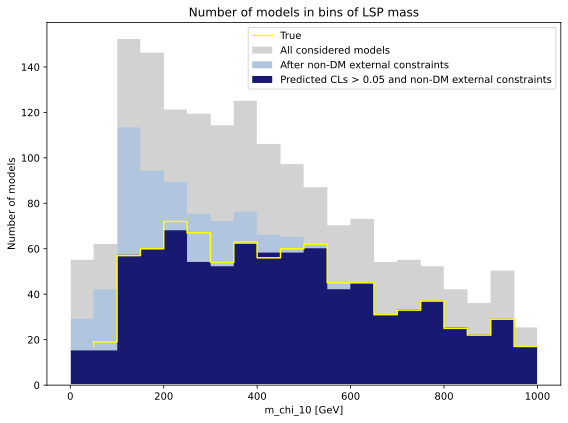

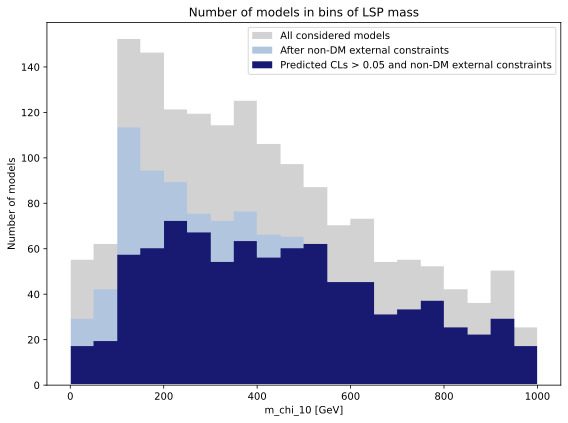

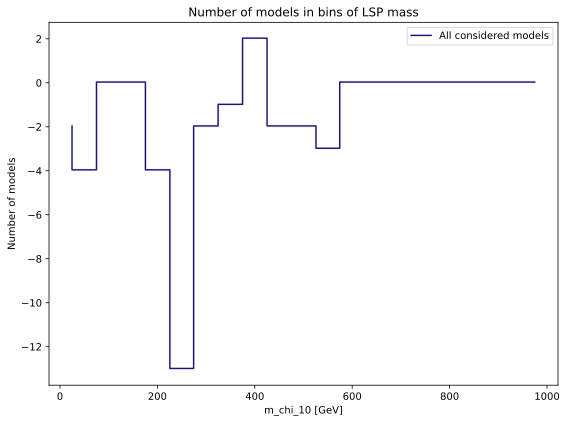

In [35]:
# Recreating figure 4 from pMSSM paper
def recreate_figure_4b_from_pMSSM_paper(df, num_bins):
    
    m_chi_10 = df["m_chi_10"]
    pred_valid_CLs_models = df["Predicted_Final__CLs"] > 0.05
    true_valid_CLs_models = df['Final__CLs'] > 0.05
    valid_external_constraints_models = (df["Constraints__Flavour"] == 1) & (df["Constraints__EW"] == 1)
    
    # For figure 4a, you need to split dataset into bino-, wino-, and higgsino-like LSP. Doesn't work well because numbers are too small to be smooth
    bino_like_LSP = df["LSP_type"] == 1
    wino_like_LSP = df["LSP_type"] == 2
    higgsino_like_LSP = df["LSP_type"] == 3
    
    # Create bins
    bins = np.linspace(0, 1000, num_bins + 1)
    bin_width = bins[1] - bins[0]
    
    # Compute number of models for each bin
    number_of_models_by_bin = []
    valid_external_constraints_by_bin = []
    pred_allowed_models_by_bin = []
    true_allowed_models_by_bin = []
    
    bin_centers = []
    
    for i in range(num_bins):
        # Find indices of values in this bin
        bin_mask = (m_chi_10 >= bins[i]) & (m_chi_10 < bins[i+1])
        valid_external_constraints_bin_mask = bin_mask & valid_external_constraints_models
        pred_all_valid = bin_mask & pred_valid_CLs_models & valid_external_constraints_models
        true_all_valid = bin_mask & true_valid_CLs_models & valid_external_constraints_models
        
        # Calculate number of models for this bin
        number_of_models = bin_mask.sum()
        num_valid_external_constraints_models = valid_external_constraints_bin_mask.sum()
        num_valid_CLs_and_external_constraints_models = pred_all_valid.sum()
        sum_true_all_valid = true_all_valid.sum()
        
        # We only have 15% of the original dataset as we trained on the first 85%. Rescale to original to make a fair comparison
        scaled_number_of_models = number_of_models / 0.15
        scaled_num_external_constraints = num_valid_external_constraints_models / 0.15
        scaled_num_of_valid_models = num_valid_CLs_and_external_constraints_models / 0.15
        
        # Store results in array
        number_of_models_by_bin.append(number_of_models)
        valid_external_constraints_by_bin.append(num_valid_external_constraints_models)
        pred_allowed_models_by_bin.append(num_valid_CLs_and_external_constraints_models)
        true_allowed_models_by_bin.append(sum_true_all_valid)
        bin_centers.append((bins[i] + bins[i+1]) / 2)
    
    # Create the plot
    plt.figure(figsize=(8,6))
    plt.bar(bin_centers, number_of_models_by_bin, width=(bins[1]-bins[0]), color="#d2d2d3", rasterized=True)
    plt.bar(bin_centers, valid_external_constraints_by_bin, width=(bins[1]-bins[0]), color="#b1c5de", rasterized=True)
    plt.bar(bin_centers, pred_allowed_models_by_bin, width=(bins[1]-bins[0]), color="#181971", rasterized=True)
    plt.step([i+bin_width/2 for i in bin_centers], true_allowed_models_by_bin, color='yellow')
    
    plt.title('Number of models in bins of LSP mass')
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('Number of models')
    
    plt.tight_layout()
    plt.legend(['True', "All considered models", "After non-DM external constraints", "Predicted CLs > 0.05 and non-DM external constraints"])
    #plt.savefig("../plots/CLs_predictor_performance/recreate_figure_4b.pdf")
    
    plt.show()
    
    # Next fig
    plt.figure(figsize=(8,6))
    plt.bar(bin_centers, number_of_models_by_bin, width=(bins[1]-bins[0]), color="#d2d2d3", rasterized=True)
    plt.bar(bin_centers, valid_external_constraints_by_bin, width=(bins[1]-bins[0]), color="#b1c5de", rasterized=True)
    plt.bar(bin_centers, true_allowed_models_by_bin, width=(bins[1]-bins[0]), color="#181971", rasterized=True)
    
    plt.title('Number of models in bins of LSP mass')
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('Number of models')
    
    plt.tight_layout()
    plt.legend(["All considered models", "After non-DM external constraints", "Predicted CLs > 0.05 and non-DM external constraints"])
    
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.step(bin_centers, np.array(pred_allowed_models_by_bin) - np.array(true_allowed_models_by_bin), color="#181971", rasterized=True)
    
    plt.title('Number of models in bins of LSP mass')
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('Number of models')
    
    plt.tight_layout()
    plt.legend(["All considered models", "After non-DM external constraints", "Predicted CLs > 0.05 and non-DM external constraints"])

recreate_figure_4b_from_pMSSM_paper(Final__CLs_output_df, 20)

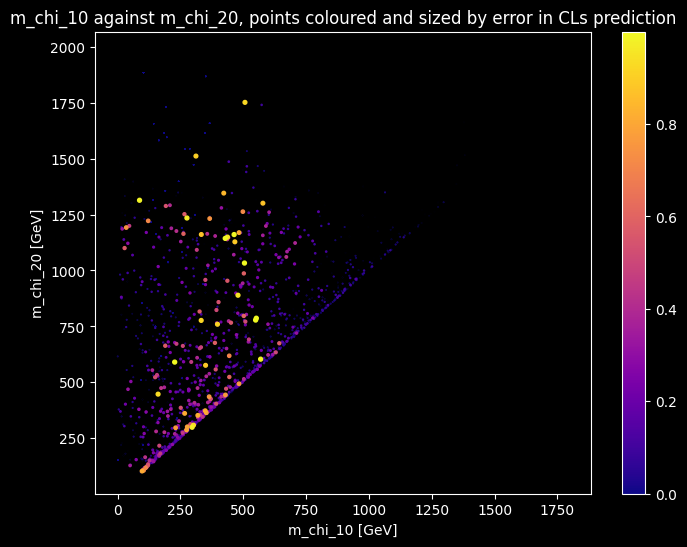

In [16]:
def scatter_plot_of_MAE(df):
    
    sorted_df = df
    sorted_df["abs_error"] = abs(df["Final__CLs"] - df["Predicted_Final__CLs"])
    sorted_df = sorted_df.sort_values(by='abs_error')
    
    # Get 1st and 2nd neutralino masses for each SUSY model
    m_chi_10 = sorted_df["m_chi_10"]
    m_chi_20 = sorted_df["m_chi_20"]
    
    # Get error in CLs prediction for each model
    abs_pred_error = sorted_df['abs_error']
    
    # Identify models for which error is large (i.e. prediction is bad)
    large_errors = abs_pred_error > 0.02
    
    plt.style.use('dark_background')
    
    plt.figure(figsize=(8,6))
    plt.scatter(m_chi_10, m_chi_20, c=abs_pred_error, cmap='plasma', s=abs_pred_error*8) #s=abs_pred_error*5
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('m_chi_20 [GeV]')
    plt.colorbar()
    plt.title('m_chi_10 against m_chi_20, points coloured and sized by error in CLs prediction')
    #plt.savefig('../plots/CLs_predictor_performance/4l_128n_75e_MAE_plots/scatter_plot_coloured_by_CLs_error.png')
    
    '''
    plt.figure(figsize=(8,6))
    plt.scatter(m_chi_10[large_errors], m_chi_20[large_errors], c=abs_pred_error[large_errors], cmap='plasma', s=abs_pred_error[large_errors]*10)
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('m_chi_20 [GeV]')
    plt.colorbar()
    '''

scatter_plot_of_MAE(df=output_df)

In [2]:
def create_heatmap(x_labels, y_labels, data_to_plot, colorbar_label=None, save=False):
    
    # Create new plot
    fig, ax = plt.subplots()
    plot = ax.pcolormesh(x_labels, y_labels, data_to_plot, cmap='plasma', rasterized=True, vmin=0, vmax=1)
    
    # Add colorbar and colorbar label
    if colorbar_label != None:
        cbar = plt.colorbar(plot)
        cbar.set_label(colorbar_label, fontsize=12, loc='top')
    
    # Define x-axis range and add x-axis label
    ax.set_xlabel(r'$m(\tilde{\chi}_1^0)$ [GeV]', loc='right', fontsize=12)
    ax.set_xlim([min(x_labels), max(x_labels)])
    
    # Define y-axis range and add y-axis label
    ax.set_ylabel(r'$m(\tilde{\chi}_2^0)$ [GeV]', loc='top', fontsize=12)
    ax.set_ylim([min(y_labels), max(y_labels)])
    
    # Ensure bins are plotted square
    ax.set_aspect('equal')
    
    if save == True:
        plt.savefig('../plots/CLs_predictor_performance/4l_128n_75e_MAE_plots/heatmaps/diff_mean_CLs.pdf')
    
    return plot

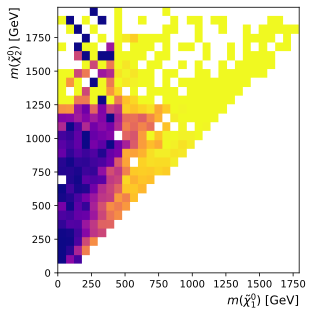

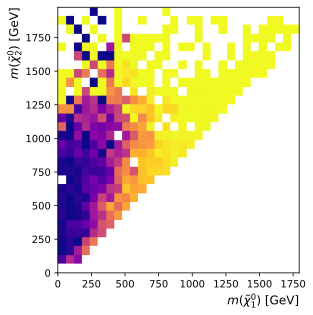

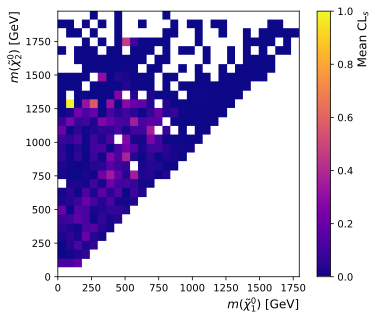

In [ ]:
def heatmap(df: pd.DataFrame, CLs_type: str, num_bins: int):
    
    true_CLs_name = f'{CLs_type}__ObsCLs'
    pred_CLs_name = f'Predicted_{CLs_type}_CLs'
    if CLs_type == 'Final__CLs': # Final__CLs column name is in different form
        true_CLs_name = 'Final__CLs'
        pred_CLs_name = 'Predicted_Final__CLs'
    
    plt.style.use('default')
    
    # Get 1st and 2nd neutralino masses for each SUSY model
    m_chi_10 = df["m_chi_10"]
    m_chi_20 = df["m_chi_20"]
    
    # Create mass bins for plotting    
    M1_bins = np.linspace(0, max(m_chi_10), num_bins+1)
    M2_bins = np.linspace(0, max(m_chi_20), num_bins+1)
    
    mean_true_CLs = []
    mean_pred_CLs = []
    model_count = []
    CLs_MAE = []
    correct_exclusions = []
    
    for i in range(num_bins): # loops over rows
        
        mean_j_true_CLs = []
        mean_j_pred_CLs = []
        j_model_count = []
        j_CLs_MAE = []
        j_correct_exclusions = []
        
        for j in range(num_bins): # loops over each bin in particular row
            
            # Select models in particular bin
            bin_mask = (m_chi_10 >= M1_bins[j]) & (m_chi_10 < M1_bins[j+1]) & (m_chi_20 >= M2_bins[i]) & (m_chi_20 < M2_bins[i+1])
            
            # Get true and predicted CLs in bin
            bin_true_CLs = df[bin_mask][true_CLs_name]
            bin_pred_CLs = df[bin_mask][pred_CLs_name]
            
            # Get mean true and predicted CLs in bin
            mean_bin_true_CLs = bin_true_CLs.mean()
            mean_bin_pred_CLs = bin_pred_CLs.mean()
            
            # Get number of models in bin
            bin_model_count = bin_mask.sum()
            if bin_model_count == 0:
                bin_model_count = float("nan")
                
            # Get MAE in bin
            bin_MAE = abs(bin_true_CLs - bin_pred_CLs).mean()
            
            # Get number of correctly excluded models in each bin
            bin_correct_exclusions = ((df[bin_mask][true_CLs_name] < 0.05) & (df[bin_mask][pred_CLs_name] < 0.05)).sum()
            if bin_correct_exclusions == 0:
                bin_correct_exclusions = float("nan")
            
            mean_j_true_CLs.append(mean_bin_true_CLs)
            mean_j_pred_CLs.append(mean_bin_pred_CLs)
            j_model_count.append(bin_model_count)
            j_CLs_MAE.append(bin_MAE)
            j_correct_exclusions.append(bin_correct_exclusions)
            
        mean_true_CLs.append(mean_j_true_CLs)
        mean_pred_CLs.append(mean_j_pred_CLs)
        model_count.append(j_model_count)
        CLs_MAE.append(j_CLs_MAE)
        correct_exclusions.append(j_correct_exclusions)
    
    # Convert arrays into numpy form for easier plotting
    mean_true_CLs = np.array(mean_true_CLs)
    mean_pred_CLs = np.array(mean_pred_CLs)
    model_count = np.array(model_count)
    CLs_MAE = np.array(CLs_MAE)
    correct_exclusions = np.array(correct_exclusions)
    
    fig_true = create_heatmap(x_labels=M1_bins, y_labels=M2_bins, data_to_plot=mean_true_CLs, save=False)
    fig_pred = create_heatmap(x_labels=M1_bins, y_labels=M2_bins, data_to_plot=mean_pred_CLs, save=False)
    fig_diff = create_heatmap(x_labels=M1_bins, y_labels=M2_bins, data_to_plot=abs(mean_true_CLs-mean_pred_CLs), colorbar_label=r'Mean CL$_s$', save=False)
    
    plt.show(fig_true)
    plt.show(fig_pred)
    plt.show(fig_diff)
    
heatmap(Final__CLs_output_df, 'Final__CLs', 30)